In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import scipy.stats as sps
import seaborn as sns
import pandas as pd
import numpy as np
import csv

import plot_utils
from util import INST_NAME_ALIASES, binomial_confidence_interval, load_in_data
from scipy.stats import mannwhitneyu, ks_2samp, chisquare, chi2_contingency, ttest_ind, ranksums
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.graphics.gofplots import ProbPlot

from matplotlib import ticker
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

%matplotlib inline

/Users/allisonmorgan/Dropbox/Faculty Social Mobility/code/plot_utils.py:39: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [


In [2]:
respondents_zip = pd.read_csv('../data/coded_data/data_linked.csv', low_memory=False)

In [3]:
## Add in PhD prestige?
max_dept_usnwr = respondents_zip.groupby(['likely_department'])['phd_USNWR'].max()
max_dept_nrc = respondents_zip.groupby(['likely_department'])['phd_NRC'].max()

def rank_scalar(row):
    if (row['likely_department'] in max_dept_usnwr) and not np.isnan(max_dept_usnwr[row['likely_department']]):
        return 100*np.divide(row['phd_USNWR'], max_dept_usnwr[row['likely_department']])
    elif (row['likely_department'] in max_dept_nrc) and not np.isnan(max_dept_nrc[row['likely_department']]):
        return 100*np.divide(row['phd_NRC'], max_dept_nrc[row['likely_department']])
    else:
        return np.nan

respondents_zip['phd_rank_scaled'] = respondents_zip.apply(rank_scalar, axis=1)
respondents_zip['phd_rank_scaled'].isna().value_counts()

False    4929
True     3080
Name: phd_rank_scaled, dtype: int64

In [4]:
respondents_zip['phd_rank_scaled'].describe()

count    4929.000000
mean       18.114706
std        19.857978
min         0.425532
25%         3.030303
50%        11.059908
75%        26.382979
max       100.000000
Name: phd_rank_scaled, dtype: float64

In [5]:
respondents_zip['parents_had_phd'] = (respondents_zip['parents_highest_edu_coded'] == 'Doctoral degree')
respondents_zip.loc[respondents_zip['parents_highest_edu_coded'].isna(), 'parents_had_phd'] = np.nan

In [6]:
respondents_zip['parents_highest_edu_coded'] = respondents_zip['parents_highest_edu_coded'].map({
    "Elementary: 0-8 years": "Elementary", "High school: 1-3 years": "Some HS", 
    "High school: 4 years": "HS", "College: 1-3 years": "Some College", "College: 4+ years": "College", 
    "Master's or professional degree": "Masters", "Doctoral degree": "PhD"})
respondents_zip['parents_highest_edu_coded'].value_counts()

Masters         2134
PhD             1604
College         1407
HS               987
Some College     683
Some HS          210
Elementary       184
Name: parents_highest_edu_coded, dtype: int64

In [7]:
respondents_zip['White'] = (respondents_zip['white'] == 1)
respondents_zip['Black'] = (respondents_zip['black'] == 1)
respondents_zip['Hisp'] = (respondents_zip['hisp'] == 1)
respondents_zip['Asian'] = (respondents_zip['asian'] == 1)
respondents_zip['Native'] = (respondents_zip['native'] == 1)
respondents_zip['Hawaii'] = (respondents_zip['hawaii'] == 1)
respondents_zip['Gender'] = respondents_zip['gender_ans'].replace('Prefer not to say', np.nan)

In [8]:
respondents_zip['STD_avg_income'] = (respondents_zip['avg_income'] - respondents_zip['avg_income'].mean())/respondents_zip['avg_income'].std()

In [9]:
respondents_zip.groupby(['parents_highest_edu_coded'])['rank_scaled'].describe()

,count,mean,std,min,25%,50%,75%,max
parents_highest_edu_coded,,,,,,,,
College,1276.0,38.344425,26.288177,0.425532,16.595745,32.795699,56.849315,100.0
Elementary,173.0,42.655107,26.581571,0.537634,19.178082,41.474654,62.328767,100.0
HS,882.0,41.581818,27.552328,0.425532,17.972350,37.327189,60.368664,100.0
Masters,1930.0,37.027710,27.081390,0.425532,14.042553,31.063830,56.565657,100.0
PhD,1470.0,33.285734,26.601761,0.425532,10.752688,26.382979,50.000000,100.0
Some College,612.0,40.594504,27.321117,0.425532,17.972350,35.484987,59.677419,100.0
Some HS,196.0,40.621510,27.802670,0.425532,16.648936,36.943164,61.868687,100.0


In [10]:
# fig, ax = plt.subplots(1, 1, dpi=75)
# for lvl in ['Some College', 'College', "Masters", 'PhD']:
#     respondents_zip.loc[respondents_zip['parents_highest_edu_coded'] == lvl, 'rank_scaled'].hist(
#         density=True, ax = ax, grid=False, alpha=0.2, label=lvl)

# plt.legend(ncol=1, frameon=False)
# plt.tight_layout()
# plt.title('Current Institutional Prestige')
# plot_utils.finalize(ax)

In [11]:
respondents_zip.groupby(['parents_highest_edu_coded'])['phd_rank_scaled'].describe()

,count,mean,std,min,25%,50%,75%,max
parents_highest_edu_coded,,,,,,,,
College,977.0,18.901214,19.993809,0.425532,3.030303,11.643836,28.125000,100.000000
Elementary,90.0,21.138664,20.413920,0.425532,6.806198,15.893308,28.282828,93.087558
HS,676.0,23.942837,22.513885,0.425532,6.164384,16.595745,36.249281,100.000000
Masters,1498.0,16.774350,18.839047,0.425532,2.898551,9.787234,23.972603,100.000000
PhD,1093.0,13.606420,17.146613,0.425532,2.553191,7.070707,18.181818,100.000000
Some College,454.0,21.765941,21.400677,0.425532,6.060606,14.267653,31.679001,92.929293
Some HS,118.0,20.943398,21.128111,0.425532,5.421402,11.643836,35.353535,95.959596


In [12]:
# fig, ax = plt.subplots(1, 1, dpi=75)
# for lvl in ['Some College', 'College', 'Masters', 'PhD']:
#     respondents_zip.loc[respondents_zip['parents_highest_edu_coded'] == lvl, 'phd_rank_scaled'].hist(
#         density=True, ax = ax, grid=False, alpha=0.2, label=lvl)

# plt.legend(ncol=1, frameon=False)
# plt.tight_layout()
# plt.title('PhD Prestige')
# plot_utils.finalize(ax)

### Define function that bootstraps CIs

In [13]:
def ols_bootstrap_results(model_eq, data, num_resamples = 1000, alpha = 0.05):
    import statsmodels.api as sm

    #get non-bootstrapped model 
    mod_full = smf.ols(model_eq, data = data)
    res_full = mod_full.fit()
    df_results = pd.DataFrame(res_full.params).T

    # bootstrapping for CIs 
    df_bootstraps = pd.DataFrame()

    #get feature matrix for people included in the full model
    data_filtered = pd.DataFrame(mod_full.exog, columns = mod_full.exog_names)
    data_filtered['endog'] = mod_full.endog
    
    for i in range(num_resamples):
        #sample people with replacement, making sure our list of people are those who meet regression criteria
        data_sample = data_filtered.sample(frac = 1, replace = True)
        
        # train model
        mod = sm.OLS(data_sample['endog'], data_sample.iloc[:,:-1]) 
        res = mod.fit()

        #add parameter estimates to df_bootstraps
        df_bootstraps = df_bootstraps.append(pd.DataFrame(res.params).T, ignore_index = True)
    
    
    # calculate confidence interval (based on alpha)
    df_results = df_results.append(df_bootstraps.quantile(alpha/2))
    df_results = df_results.append(df_bootstraps.quantile(1 - (alpha/2)))
    
    # check if param is significant at alpha
    df_results = df_results.T
    df_results['*'] = df_results.apply(lambda row: '' if row[alpha/2] < 0 <row[1 - (alpha/2)] else '*', 
                                       axis = 1)
    df_results['sem'] = df_bootstraps.sem().values
    #df_results['sem'] = df_results.append(df_bootstraps.sem())
    
    #rename column for clarity
    df_results.rename(columns={0: 'coef'}, inplace=True)
    df_results = df_results.round(3)
    
    return df_results

In [14]:
# https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(y, model_fit):
    """
    Function to reproduce the 4 base plots of an OLS model in R.
    ---
    Inputs:

    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model
    model_fit: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """
    color = 'blue'
    model_fitted_y = model_fit.fittedvalues     # model values
    model_residuals = model_fit.resid     # model residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal     # normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))     # absolute squared normalized residuals
    model_abs_resid = np.abs(model_residuals)     # absolute residuals
    model_leverage = model_fit.get_influence().hat_matrix_diag     # leverage, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]     # cook's distance, from statsmodels internals

    fig, plot_lm = plt.subplots(2, 2, figsize=(8, 6))
    sns.residplot(x=model_fitted_y, y=y, lowess=True, scatter_kws={'alpha': 0.5}, color=color,
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=plot_lm[0][0])

    plot_lm[0][0].set_title('Residuals vs Fitted')
    plot_lm[0][0].set_xlabel('Fitted values')
    plot_lm[0][0].set_ylabel('Residuals');

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm[0][0].annotate(i, xy=(model_fitted_y[i], model_residuals[i]))

    QQ = ProbPlot(model_norm_residuals)
    QQ.qqplot(line='45', alpha=0.5, color=color, lw=1, ax=plot_lm[0][1])
    plot_lm[0][1].set_title('Normal Q-Q')
    plot_lm[0][1].set_xlabel('Theoretical Quantiles')
    plot_lm[0][1].set_ylabel('Standardized Residuals');
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm[0][1].annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r], model_norm_residuals[i]))

    plot_lm[1][0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5, color=color);
    sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=plot_lm[1][0], color=color);
    plot_lm[1][0].set_title('Scale-Location')
    plot_lm[1][0].set_xlabel('Fitted values')
    plot_lm[1][0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        try:
            plot_lm[1][0].annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]))
        except:
            continue

    plot_lm[1][1].scatter(model_leverage, model_norm_residuals, alpha=0.5, color=color);
    sns.regplot(x=model_leverage, y=model_norm_residuals, scatter=False, ci=False, lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=plot_lm[1][1], color=color);
    plot_lm[1][1].set_xlim(0, max(model_leverage)+0.01)
    plot_lm[1][1].set_ylim(-3, 5)
    plot_lm[1][1].set_title('Residuals vs Leverage')
    plot_lm[1][1].set_xlabel('Leverage')
    plot_lm[1][1].set_ylabel('Standardized Residuals');

      # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm[1][1].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));

    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm[1][1].legend(loc='upper right');
    plt.tight_layout()

## Regression analysis

### Model 1: Demographics, Discipline, Urban / Rural

In [15]:
model_fits = []

In [16]:
model_eq = 'rank_scaled ~ 1 + C(likely_department) + White + Black + Hisp + Asian + Native + Hawaii + \
                          C(Gender) + phd_rank_scaled + C(ru_class)'

mod = smf.ols(model_eq, data = respondents_zip)
res = mod.fit()
model_fits.append(res.rsquared_adj)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rank_scaled   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     21.18
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           1.63e-58
Time:                        13:54:17   Log-Likelihood:                -12875.
No. Observations:                2754   AIC:                         2.578e+04
Df Residuals:                    2737   BIC:                         2.589e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           29.2515      3.559      8.219      0.000      22.273      36.230
C(likely_department)[T.Biology]                     -1.3859      2.296     -0.604      0.546      -5.888       3.116
C(likely_department)[T.Business]                     1.2816      2.461      0.521      0.603      -3.545       6.108
C(likely_department)[T.Computer Science]          2.973e-16   2.56e-15      0.116      0.908   -4.72e-15    5.31e-15
C(likely_department)[T.History]                      8.0647      2.358      3.420      0.001       3.441      12.688
C(likely_department)[T.Physics and/or Astronomy]     0.9188      2.472      0.372      0.710      -3.928       5.765
C(likely_department)[T.Psychology]                   0.8551      2.367      0.361      0.718      -3.787       5.497
C(likely_department)[T.Sociology]                    0.9593      2.666      0.360      0.719      -4.268       6.187
White[T.True]                                        0.2041      2.521      0.081      0.935      -4.739       5.147
Black[T.True]                                       -2.3642      3.432     -0.689      0.491      -9.094       4.366
Hisp[T.True]                                        -1.4181      3.397     -0.417      0.676      -8.079       5.243
Asian[T.True]                                        1.2864      3.229      0.398      0.690      -5.045       7.618
Native[T.True]                                       1.2791      6.065      0.211      0.833     -10.612      13.171
Hawaii[T.True]                                       8.3469     13.104      0.637      0.524     -17.347      34.041
C(Gender)[T.Male]                                   -0.7794      1.043     -0.747      0.455      -2.825       1.267
C(Gender)[T.Other identity]                        -11.9778     11.690     -1.025      0.306     -34.900      10.945
C(ru_class)[T.urban]                                 0.1292      1.663      0.078      0.938      -3.132       3.390
phd_rank_scaled                                      0.4603      0.026     17.399      0.000       0.408       0.512
==============================================================================
Omnibus:                      184.414   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.492
Skew:                           0.600   Prob(JB):                     7.12e-42
Kurtosis:                       2.538   Cond. No.                     1.51e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.2e-31. This might i

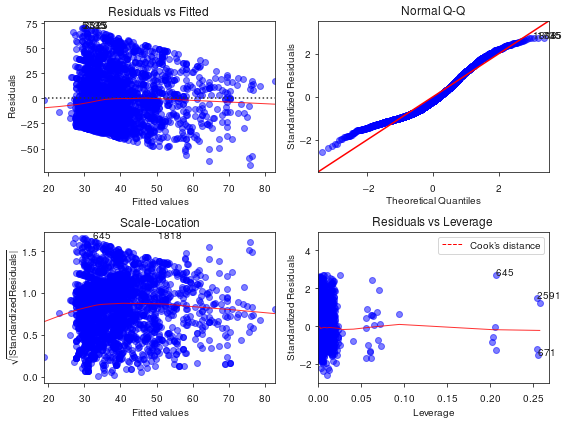

In [17]:
diagnostic_plots(mod.endog, model_fit=res)

In [18]:
#bootstrapping CIs for the above model
bootstrap_res = ols_bootstrap_results(model_eq, respondents_zip, num_resamples = 1000, alpha = 0.05)
model1 = bootstrap_res
model1

,coef,0.025,0.975,*,sem
Intercept,29.251,21.415,36.426,*,0.122
C(likely_department)[T.Biology],-1.386,-6.711,3.709,,0.087
C(likely_department)[T.Business],1.282,-4.655,6.949,,0.092
C(likely_department)[T.Computer Science],0.000,-0.000,0.000,,0.000
C(likely_department)[T.History],8.065,2.297,13.820,*,0.089
C(likely_department)[T.Physics and/or Astronomy],0.919,-4.577,6.499,,0.092
C(likely_department)[T.Psychology],0.855,-4.340,6.025,,0.087
C(likely_department)[T.Sociology],0.959,-4.816,6.739,,0.095
White[T.True],0.204,-5.297,5.588,,0.087
Black[T.True],-2.364,-10.005,5.317,,0.122


### Model 2: Plus standardized income

In [19]:
# model_eq = 'rank_scaled ~ 1 + C(likely_department) + White + Black + Hisp + Asian + Native + Hawaii + \
#                           C(Gender) + C(ru_class) + STD_avg_income'
model_eq = model_eq + '+ STD_avg_income'

mod = smf.ols(model_eq, data = respondents_zip)
res = mod.fit()
model_fits.append(res.rsquared_adj)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rank_scaled   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     20.01
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           4.49e-58
Time:                        13:54:23   Log-Likelihood:                -12661.
No. Observations:                2710   AIC:                         2.536e+04
Df Residuals:                    2692   BIC:                         2.546e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           28.5279      3.567      7.999      0.000      21.534      35.521
C(likely_department)[T.Biology]                     -1.3494      2.304     -0.586      0.558      -5.867       3.168
C(likely_department)[T.Business]                     1.8357      2.477      0.741      0.459      -3.021       6.693
C(likely_department)[T.Computer Science]           1.45e-14   4.18e-15      3.467      0.001     6.3e-15    2.27e-14
C(likely_department)[T.History]                      8.1709      2.366      3.453      0.001       3.531      12.811
C(likely_department)[T.Physics and/or Astronomy]     0.7537      2.481      0.304      0.761      -4.111       5.619
C(likely_department)[T.Psychology]                   0.9803      2.375      0.413      0.680      -3.677       5.638
C(likely_department)[T.Sociology]                    1.0732      2.676      0.401      0.688      -4.174       6.321
White[T.True]                                        0.3198      2.520      0.127      0.899      -4.621       5.261
Black[T.True]                                       -2.2274      3.435     -0.648      0.517      -8.963       4.508
Hisp[T.True]                                        -1.3253      3.418     -0.388      0.698      -8.028       5.378
Asian[T.True]                                        1.8553      3.230      0.574      0.566      -4.478       8.188
Native[T.True]                                       0.8411      6.049      0.139      0.889     -11.020      12.702
Hawaii[T.True]                                       7.8955     13.065      0.604      0.546     -17.723      33.514
C(Gender)[T.Male]                                   -0.4570      1.049     -0.436      0.663      -2.513       1.599
C(Gender)[T.Other identity]                        -11.8799     11.656     -1.019      0.308     -34.735      10.976
C(ru_class)[T.urban]                                 0.5520      1.678      0.329      0.742      -2.738       3.842
phd_rank_scaled                                      0.4512      0.027     16.900      0.000       0.399       0.504
STD_avg_income                                      -1.4466      0.455     -3.179      0.001      -2.339      -0.554
==============================================================================
Omnibus:                      180.925   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.786
Skew:                           0.604   Prob(JB):                     1.67e-41
Kurtosis:                       2.548   Cond. No.                     5.71e+17
==============================================================================

Notes:
[1] Standard Errors assume 

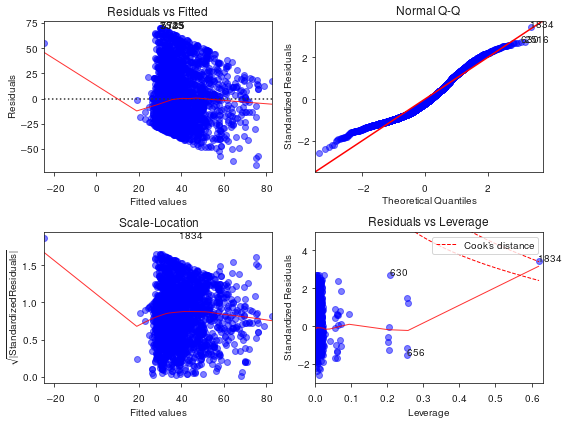

In [20]:
diagnostic_plots(mod.endog, model_fit=res)

In [21]:
#bootstrapping CIs for the above model
bootstrap_res = ols_bootstrap_results(model_eq, respondents_zip, num_resamples = 1000, alpha = 0.05)
model2 = bootstrap_res
model2

,coef,0.025,0.975,*,sem
Intercept,28.528,20.925,37.369,*,0.127
C(likely_department)[T.Biology],-1.349,-6.891,3.576,,0.085
C(likely_department)[T.Business],1.836,-3.850,7.126,,0.091
C(likely_department)[T.Computer Science],0.000,-0.000,0.000,,0.000
C(likely_department)[T.History],8.171,2.652,13.667,*,0.090
C(likely_department)[T.Physics and/or Astronomy],0.754,-5.516,6.537,,0.094
C(likely_department)[T.Psychology],0.980,-4.379,6.220,,0.087
C(likely_department)[T.Sociology],1.073,-4.746,6.235,,0.092
White[T.True],0.320,-4.857,6.007,,0.088
Black[T.True],-2.227,-9.771,5.378,,0.121


### Model 3: Plus parents' education

In [22]:
# model_eq = 'rank_scaled ~ 1 + C(likely_department) + White + Black + Hisp + Asian + Native + Hawaii + \
#                           C(Gender) + C(ru_class) + STD_avg_income + \
#                           C(parents_highest_edu_coded, Treatment("Some College"))'
model_eq = model_eq + '+ C(parents_highest_edu_coded, Treatment("Some College"))'

mod = smf.ols(model_eq, data = respondents_zip)
res = mod.fit()
model_fits.append(res.rsquared_adj)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rank_scaled   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     15.37
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           7.60e-57
Time:                        13:54:29   Log-Likelihood:                -12650.
No. Observations:                2709   AIC:                         2.535e+04
Df Residuals:                    2685   BIC:                         2.549e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                33.1894      3.917      8.472      0.000      25.508      40.871
C(likely_department)[T.Biology]                                          -1.6776      2.304     -0.728      0.467      -6.196       2.841
C(likely_department)[T.Business]                                          1.7354      2.475      0.701      0.483      -3.117       6.588
C(likely_department)[T.Computer Science]                              -5.267e-15   3.78e-15     -1.395      0.163   -1.27e-14    2.14e-15
C(likely_department)[T.History]                                           8.1710      2.365      3.454      0.001       3.533      12.809
C(likely_department)[T.Physics and/or Astronomy]                          0.8129      2.482      0.328      0.743      -4.054       5.680
C(likely_department)[T.Psychology]                                        0.7616      2.375      0.321      0.749      -3.896       5.419
C(likely_department)[T.Sociology]                                         0.9165      2.677      0.342      0.732      -4.332       6.165
White[T.True]                                                             0.6891      2.527      0.273      0.785      -4.266       5.644
Black[T.True]                                                            -2.1389      3.437     -0.622      0.534      -8.878       4.600
Hisp[T.True]                                                             -1.6095      3.424     -0.470      0.638      -8.323       5.104
Asian[T.True]                                                             2.1790      3.242      0.672      0.502      -4.178       8.536
Native[T.True]                                                            0.8260      6.053      0.136      0.891     -11.043      12.695
Hawaii[T.True]                                                            8.5075     13.060      0.651      0.515     -17.102      34.117
C(Gender)[T.Male]                                                        -0.6775      1.052     -0.644      0.520      -2.740       1.385
C(Gender)[T.Other identity]                                             -12.9463     11.651     -1.111      0.267     -35.791       9.899
C(ru_class)[T.urban]                                                      0.9140      1.689      0.541      0.588      -2.398       4.226
C(parents_highest_edu_coded, Treatment("Some College"))[T.College]       -4.4158      2.031     -2.174      0.030      -8.398      -0.433
C(parents_highest_edu_coded, Treatment("Some College"))[T.Elementary]    -2.9459      5.309     -0.555      0.579     -13.356       7.465
C(parents_highest_edu_coded, Treatment("Some Co

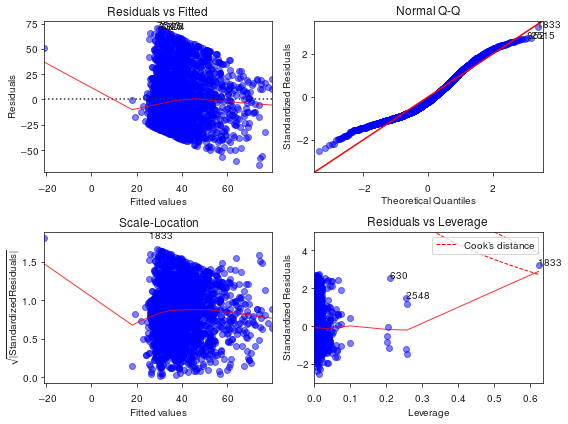

In [23]:
diagnostic_plots(mod.endog, model_fit=res)

In [24]:
#bootstrapping CIs for the above model
bootstrap_res = ols_bootstrap_results(model_eq, respondents_zip, num_resamples = 1000, alpha = 0.05)
model3 = bootstrap_res
model3

,coef,0.025,0.975,*,sem
Intercept,33.189,25.069,41.605,*,0.133
C(likely_department)[T.Biology],-1.678,-6.888,3.147,,0.083
C(likely_department)[T.Business],1.735,-3.809,7.026,,0.088
C(likely_department)[T.Computer Science],-0.000,-0.000,0.000,,0.000
C(likely_department)[T.History],8.171,3.028,13.179,*,0.085
C(likely_department)[T.Physics and/or Astronomy],0.813,-5.023,6.441,,0.089
C(likely_department)[T.Psychology],0.762,-4.509,5.718,,0.084
C(likely_department)[T.Sociology],0.917,-4.806,6.112,,0.091
White[T.True],0.689,-4.788,6.355,,0.090
Black[T.True],-2.139,-9.186,5.684,,0.118


### Export to Latex

In [27]:
table = pd.DataFrame()
coeficients = ['phd_rank_scaled', 'C(ru_class)[T.urban]', 'STD_avg_income', 
               'C(parents_highest_edu_coded, Treatment("Some College"))[T.Elementary]',
               'C(parents_highest_edu_coded, Treatment("Some College"))[T.Some HS]',
               'C(parents_highest_edu_coded, Treatment("Some College"))[T.HS]',
               'C(parents_highest_edu_coded, Treatment("Some College"))[T.College]',
               'C(parents_highest_edu_coded, Treatment("Some College"))[T.Masters]',
               'C(parents_highest_edu_coded, Treatment("Some College"))[T.PhD]']
for i, (name, mod_i) in enumerate([('Model I', model1), ('Model II', model2), ('Model III', model3)]):
    results = []
    for coef in coeficients:
        try:
            val, lwr, upr, sig, sem = mod_i.loc[coef].values
            results.append('{:.3f} {:s}'.format(val, sig))
            results.append('({:.3f})'.format(sem))
        except:
            results.append('')
            results.append('')
    
    results.append('{:.3f}'.format(model_fits[i]))
    table[name] = results
table.index = ['PhD Prestige', '', 'Urban neighborhood', '', 'Avg. income', '', 'Elementary', '', 
               'Some HS', '', 'HS', '', 'College', '', 'Masters', '', 'PhD', '','Adjusted R2']

In [28]:
print(table.to_latex())

\begin{tabular}{llll}
\toprule
{} &  Model I &  Model II & Model III \\
\midrule
PhD Prestige       &  0.460 * &   0.451 * &   0.440 * \\
                   &  (0.001) &   (0.001) &   (0.001) \\
Urban neighborhood &   0.129  &    0.552  &    0.914  \\
                   &  (0.050) &   (0.052) &   (0.054) \\
Avg. income        &          &  -1.447 * &  -1.352 * \\
                   &          &   (0.037) &   (0.038) \\
Elementary         &          &           &   -2.946  \\
                   &          &           &   (0.172) \\
Some HS            &          &           &   -1.816  \\
                   &          &           &   (0.191) \\
HS                 &          &           &  -4.873 * \\
                   &          &           &   (0.065) \\
College            &          &           &  -4.416 * \\
                   &          &           &   (0.063) \\
Masters            &          &           &  -5.177 * \\
                   &          &           &   (0.059) \\
PhD    